Generate temperature, salinity, nutrient, u and v boundary files, and T, S, nutrient initial conditions from run42.

## Generate initial and boundary conditions from run42

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import xarray as xr
import canyon_tools.readout_tools as rdout

In [2]:
gridCan_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
gridNoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/stateGlob.nc'
ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/ptracersGlob.nc'

gridNoC = xr.open_dataset(gridNoC_file)
gridCan = xr.open_dataset(gridCan_file)
state = xr.open_dataset(state_file)
ptracers = xr.open_dataset(ptracers_file)

### Get slice for boundary conditions

I chose a cross section at xi = 120 gridpoints from west boundary.

Time index is tt=6 for day 3.

xslice = 120
timeslice = 6

In [3]:
u_bdy = state.U.isel(Xp1=120, T=6)
v_bdy = state.V.isel(X=120, T=6)

In [4]:
# Save binary file

dt = np.dtype('>f8')  # float 64 big endian

u_file = "u_OBCS_run42_day03.bin"
fileobj1 = open(u_file,mode='wb')
np.array(u_bdy).astype(dt).tofile(fileobj1,"")
fileobj1.close()

v_file = "v_OBCS_run42_day03.bin"
fileobj2 = open(v_file,mode='wb')
np.array(v_bdy).astype(dt).tofile(fileobj2,"")
fileobj2.close()


(1, 360, 90)
(1, 361, 90)


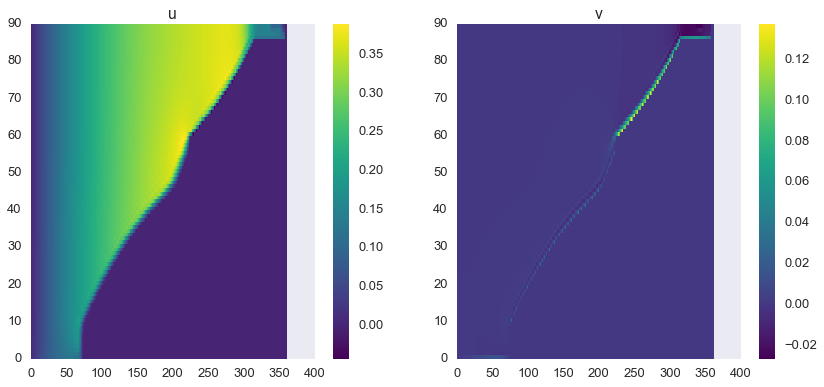

In [5]:
# Check what we wrote
fileNAME = "u_OBCS_run42_day03.bin" 
datau = np.fromfile(fileNAME, dt)

u_check = np.reshape(datau,(1,360,90),order='F')
print(np.shape(u_check))

fileNAME = "v_OBCS_run42_day03.bin" 
datav = np.fromfile(fileNAME, dt)

v_check = np.reshape(datav,(1,361,90),order='F')
print(np.shape(v_check))

sns.set_context('talk')
fig,ax = plt.subplots(1,2,figsize=(14,6))

pcol1 = ax[0].pcolor(np.flipud(np.transpose(u_check[0,:,:])), cmap = 'viridis')
plt.colorbar(pcol1,ax = ax[0])
ax[0].set_title('u')

pcol2 = ax[1].pcolor(np.flipud(np.transpose(v_check[0,:,:])), cmap = 'viridis')
plt.colorbar(pcol2,ax = ax[1])
ax[1].set_title('v')

## Generate initial conditions (T, S, Tr)
Initial conditions from run42 (new base case, no canyon). First, save T, S, and TR at day 3 to use an initial conditions of a no canyon case.

Then try to generate from this fields, an applicable interpolation within the canyon:
For every depth, find the first fully closed cell (HFacC=0) along the y direction and from that index on substitute the 0 value of the field (masked value) with the one right before the shelf.

**Initial conditions for no canyon case**

In [3]:
Temperature_day3 = state.Temp.isel(T=6)
Salinity_day3 = state.S.isel(T=6)
Tracer_day3 = ptracers.Tr1.isel(T=6)

Temperature_day3_arr = np.array(Temperature_day3.data)
Salinity_day3_arr = np.array(Salinity_day3.data)
Tracer_day3_arr = np.array(Tracer_day3.data)

# save binary files
dt = np.dtype('>f8')  # float 64 big endian

IC_temp_file = "tmp_run42_day03_NoC.bin"
fileobj1 = open(IC_temp_file,mode='wb')
np.array(Temperature_day3_arr).astype(dt).tofile(fileobj1,"")
fileobj1.close()

IC_sal_file = "sal_run42_day03_NoC.bin"
fileobj2 = open(IC_sal_file,mode='wb')
np.array(Salinity_day3_arr).astype(dt).tofile(fileobj2,"")
fileobj2.close()

IC_tr_file = "trc_run42_day03_NoC.bin"
fileobj3 = open(IC_tr_file,mode='wb')
np.array(Tracer_day3_arr).astype(dt).tofile(fileobj3,"")
fileobj3.close()

** Canyon case interpolation **

In [7]:
Temperature_CS = state.Temp.isel(X=120,T=6)
Salinity_CS = state.S.isel(X=120,T=6)
Tracer_CS = ptracers.Tr1.isel(X=120,T=6)

Temperature_CS_ext = np.array(Temperature_CS.data)
Salinity_CS_ext = np.array(Salinity_CS.data)
Tracer_CS_ext = np.array(Tracer_CS.data)


Original CS fields


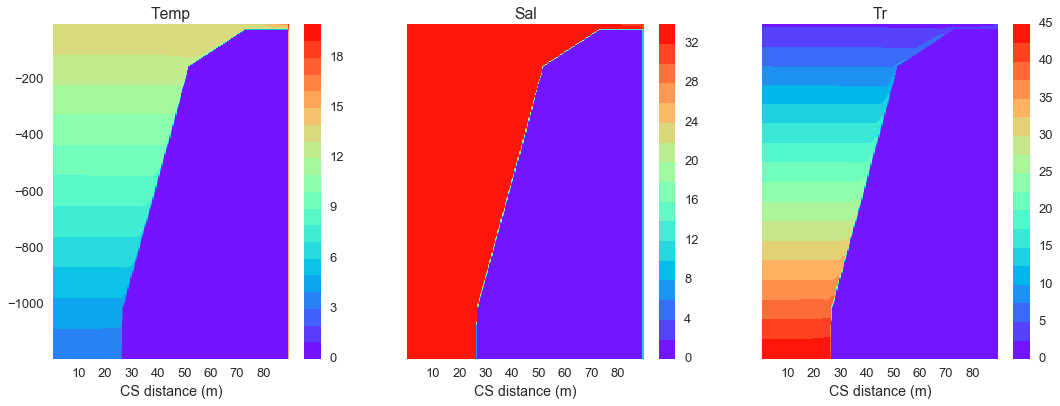

In [9]:
sns.set_context('talk')
fig,ax = plt.subplots(1,3,figsize=(18,6), sharey = True)

cf1 = ax[0].contourf(gridNoC.YC[:,120]/1000,gridNoC.RC,Temperature_CS,20, cmap = 'rainbow')
plt.colorbar(cf1,ax = ax[0])
ax[0].set_title('Temp')
ax[0].set_xlabel('CS distance (m)')

cf2 = ax[1].contourf(gridNoC.YC[:,120]/1000,gridNoC.RC,Salinity_CS,20, cmap = 'rainbow')
plt.colorbar(cf2,ax = ax[1])
ax[1].set_title('Sal')
ax[1].set_xlabel('CS distance (m)')

cf3 = ax[2].contourf(gridNoC.YC[:,120]/1000,gridNoC.RC,Tracer_CS,20, cmap = 'rainbow')
plt.colorbar(cf3,ax = ax[2])
ax[2].set_title('Tr')
ax[2].set_xlabel('CS distance (m)')

print('Original CS fields')

In [13]:
LandInd = np.nanargmin(gridNoC.HFacC[:,:,120],axis=1) # first land cell from open ocean to coast on a CS slice
print(np.shape(LandInd))

for kk in range(90):
    Temperature_CS_ext[kk,:][Temperature_CS_ext[kk,:]==0.0] = Temperature_CS[kk,LandInd[kk]-1]
    Salinity_CS_ext[kk,:][Salinity_CS_ext[kk,:]==0.0] = Salinity_CS[kk,LandInd[kk]-1]
    Tracer_CS_ext[kk,:][Tracer_CS_ext[kk,:]==0.0] = Tracer_CS[kk,LandInd[kk]-1]
        

(90,)


Extended fields


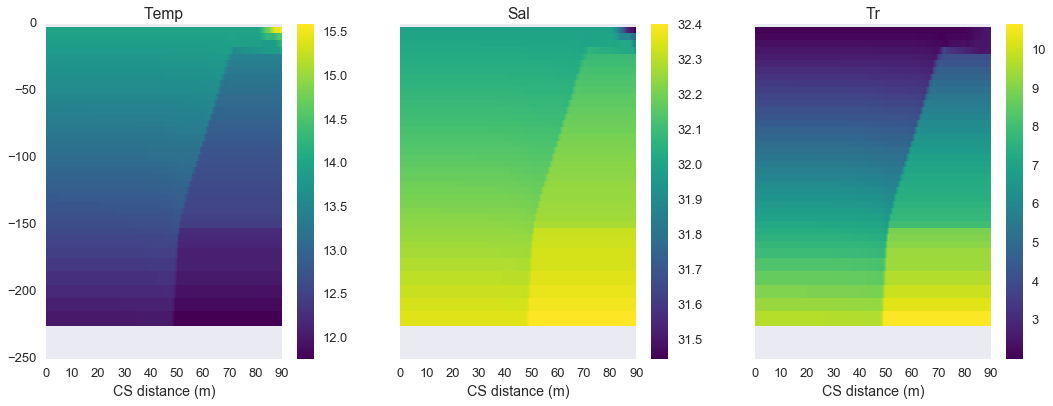

In [14]:
sns.set_context('talk')
fig,ax = plt.subplots(1,3,figsize=(18,6), sharey = True)

pcol1 = ax[0].pcolor(gridNoC.YC[:,120]/1000,gridNoC.RC[:40],Temperature_CS_ext[:40,:], cmap = 'viridis')
plt.colorbar(pcol1,ax = ax[0])
ax[0].set_title('Temp')
ax[0].set_xlabel('CS distance (m)')

pcol2 = ax[1].pcolor(gridNoC.YC[:,120]/1000,gridNoC.RC[:40],Salinity_CS_ext[:40,:], cmap = 'viridis')
plt.colorbar(pcol2,ax = ax[1])
ax[1].set_title('Sal')
ax[1].set_xlabel('CS distance (m)')

pcol3 = ax[2].pcolor(gridNoC.YC[:,120]/1000,gridNoC.RC[:40],Tracer_CS_ext[:40,:], cmap = 'viridis')
plt.colorbar(pcol3,ax = ax[2])
ax[2].set_title('Tr')
ax[2].set_xlabel('CS distance (m)')

print('Extended fields')

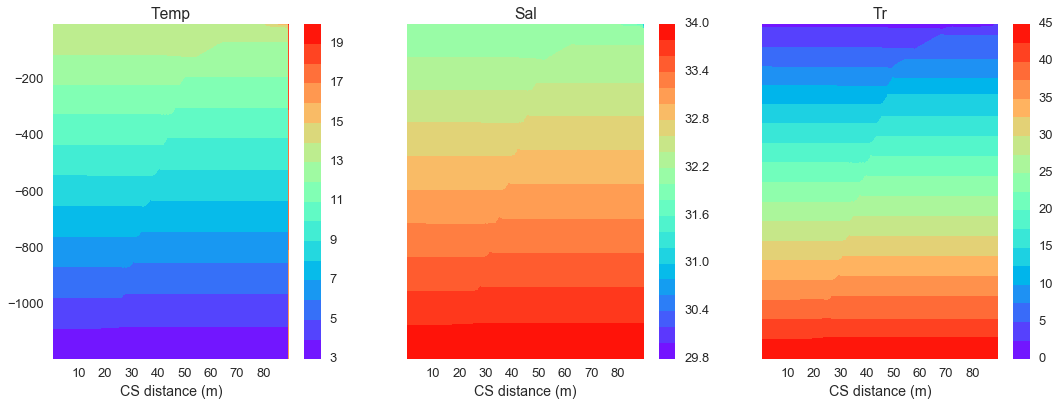

In [15]:
sns.set_context('talk')
fig,ax = plt.subplots(1,3,figsize=(18,6), sharey = True)

cf1 = ax[0].contourf(gridNoC.YC[:,120]/1000,gridNoC.RC[:],Temperature_CS_ext,20, cmap = 'rainbow')
plt.colorbar(cf1,ax = ax[0])
ax[0].set_title('Temp')
ax[0].set_xlabel('CS distance (m)')

cf2 = ax[1].contourf(gridNoC.YC[:,120]/1000,gridNoC.RC[:],Salinity_CS_ext,20, cmap = 'rainbow')
plt.colorbar(cf2,ax = ax[1])
ax[1].set_title('Sal')
ax[1].set_xlabel('CS distance (m)')

cf3 = ax[2].contourf(gridNoC.YC[:,120]/1000,gridNoC.RC[:],Tracer_CS_ext,20, cmap = 'rainbow')
plt.colorbar(cf3,ax = ax[2])
ax[2].set_title('Tr')
ax[2].set_xlabel('CS distance (m)')


In [16]:
# Extend cross section in alongshelf dimension (x) to get 3D fields. 
# - I am assuming coastal upwelling is symmetrical alongshelf, which sounds reasonable 
# and is what I see in the no canyon cases.-

Temperature_CS_exp = np.expand_dims(Temperature_CS_ext,2)
Temperature_CS_exp = Temperature_CS_exp + np.zeros(gridNoC.HFacC.shape)

Salinity_CS_exp = np.expand_dims(Salinity_CS_ext,2)
Salinity_CS_exp = Salinity_CS_exp + np.zeros(gridNoC.HFacC.shape)

Tracer_CS_exp = np.expand_dims(Tracer_CS_ext,2)
Tracer_CS_exp = Tracer_CS_exp + np.zeros(gridNoC.HFacC.shape)

print(Tracer_CS_exp.shape)

(90, 360, 360)


In [17]:
# Save IC's binary files

dt = np.dtype('>f8')  # float 64 big endian

IC_temp_file = "tmp_run42_day03.bin"
fileobj1 = open(IC_temp_file,mode='wb')
np.array(Temperature_CS_exp).astype(dt).tofile(fileobj1,"")
fileobj1.close()

IC_sal_file = "sal_run42_day03.bin"
fileobj2 = open(IC_sal_file,mode='wb')
np.array(Salinity_CS_exp).astype(dt).tofile(fileobj2,"")
fileobj2.close()

IC_tr_file = "trc_run42_day03.bin"
fileobj3 = open(IC_tr_file,mode='wb')
np.array(Tracer_CS_exp).astype(dt).tofile(fileobj3,"")
fileobj3.close()

(360, 360, 90)
(360, 360, 90)


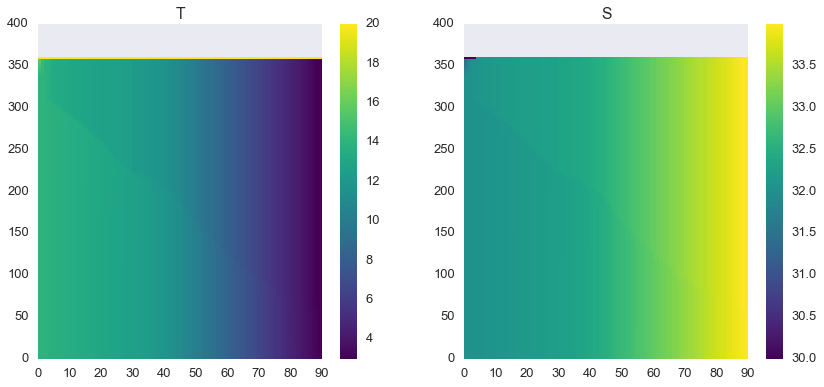

In [27]:
# Check what we wrote
fileNAME = "tmp_run42_day03.bin" 
dataT = np.fromfile(fileNAME, dt)

T_check = np.reshape(dataT,(360,360,90),order='F')
print(T_check.shape)

fileNAME = "sal_run42_day03.bin" 
dataS = np.fromfile(fileNAME, dt)

S_check = np.reshape(dataS,(360,360,90),order='F')
print(S_check.shape)

sns.set_context('talk')
fig,ax = plt.subplots(1,2,figsize=(14,6))

pcol1 = ax[0].pcolor(T_check[120,:,:], cmap = 'viridis')
plt.colorbar(pcol1,ax = ax[0])
ax[0].set_title('T')

pcol2 = ax[1].pcolor(S_check[120,:,:], cmap = 'viridis')
plt.colorbar(pcol2,ax = ax[1])
ax[1].set_title('S')

## Generate initial conditions for U, V

Generate a file with the u and v fields from day 3, run42. They should be unsatggered because MITgcm will stagger them.

In [4]:
UU = state.U.isel(T=6)
VV = state.V.isel(T=6)

# unstagger
UU_day3, VV_day3 = rdout.unstagger(UU,VV)

# save binary files
dt = np.dtype('>f8')  # float 64 big endian

IC_U_file = "uu_run42_day03_NoC.bin"
fileobj1 = open(IC_U_file,mode='wb')
np.array(UU_day3).astype(dt).tofile(fileobj1,"")
fileobj1.close()

IC_V_file = "vv_run42_day03_NoC.bin"
fileobj2 = open(IC_V_file,mode='wb')
np.array(VV_day3).astype(dt).tofile(fileobj2,"")
fileobj2.close()



(360, 360, 90)
(360, 360, 90)


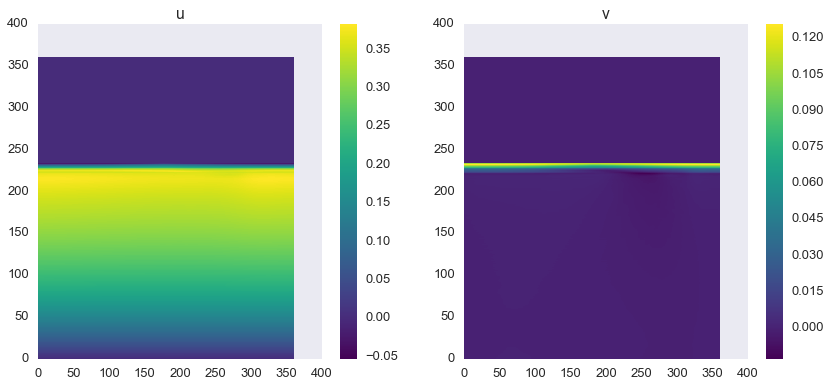

In [7]:
# Check what we wrote
fileNAME = "uu_run42_day03_NoC.bin" 
datau = np.fromfile(fileNAME, dt)

u_check = np.reshape(datau,(360,360,90),order='F')
print(np.shape(u_check))

fileNAME = "vv_run42_day03_NoC.bin" 
datav = np.fromfile(fileNAME, dt)

v_check = np.reshape(datav,(360,360,90),order='F')
print(np.shape(v_check))

sns.set_context('talk')
fig,ax = plt.subplots(1,2,figsize=(14,6))

pcol1 = ax[0].pcolor(np.transpose(u_check[:,:,28]), cmap = 'viridis')
plt.colorbar(pcol1,ax = ax[0])
ax[0].set_title('u')

pcol2 = ax[1].pcolor(np.transpose(v_check[:,:,28]), cmap = 'viridis')
plt.colorbar(pcol2,ax = ax[1])
ax[1].set_title('v')

## Generate initial conditions for U, V interpolating for the canyon

Generate a file with the u and v fields from day 3, run42. They should be unsatggered because MITgcm will stagger them.

In [3]:
UU = state.U.isel(T=6)
VV = state.V.isel(T=6)

# unstagger
UU_day3, VV_day3 = rdout.unstagger(UU,VV)


In [17]:
UU_CS = UU.isel(Xp1=120)
VV_CS = VV.isel(X=120,Yp1=slice(0,360))

UU_CS_ext = np.array(UU_CS.data)
VV_CS_ext = np.array(VV_CS.data)


Original CS fields


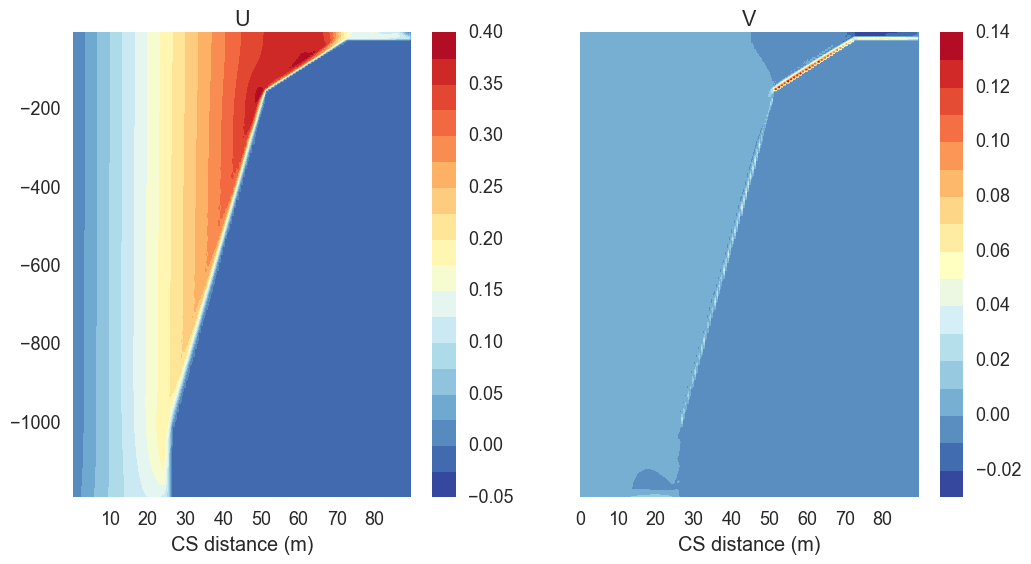

In [21]:
sns.set_context('talk')
fig,ax = plt.subplots(1,2,figsize=(12,6), sharey = True)

cf1 = ax[0].contourf(gridNoC.YC[:,120]/1000,gridNoC.RC,UU_CS,20, cmap = 'RdYlBu_r')
plt.colorbar(cf1,ax = ax[0])
ax[0].set_title('U')
ax[0].set_xlabel('CS distance (m)')


cf2 = ax[1].contourf(gridNoC.Yp1[:360]/1000,gridNoC.RC,VV_CS,20, cmap = 'RdYlBu_r')
plt.colorbar(cf2,ax = ax[1])
ax[1].set_title('V')
ax[1].set_xlabel('CS distance (m)')

print('Original CS fields')

In [22]:
LandInd = np.nanargmin(gridNoC.HFacC[:,:,120],axis=1) # first land cell from open ocean to coast on a CS slice
print(np.shape(LandInd))

for kk in range(90):
    UU_CS_ext[kk,:][UU_CS_ext[kk,:]==0.0] = UU_CS[kk,LandInd[kk]-1]
    VV_CS_ext[kk,:][VV_CS_ext[kk,:]==0.0] = VV_CS[kk,LandInd[kk]-1]
        

(90,)


Extended fields


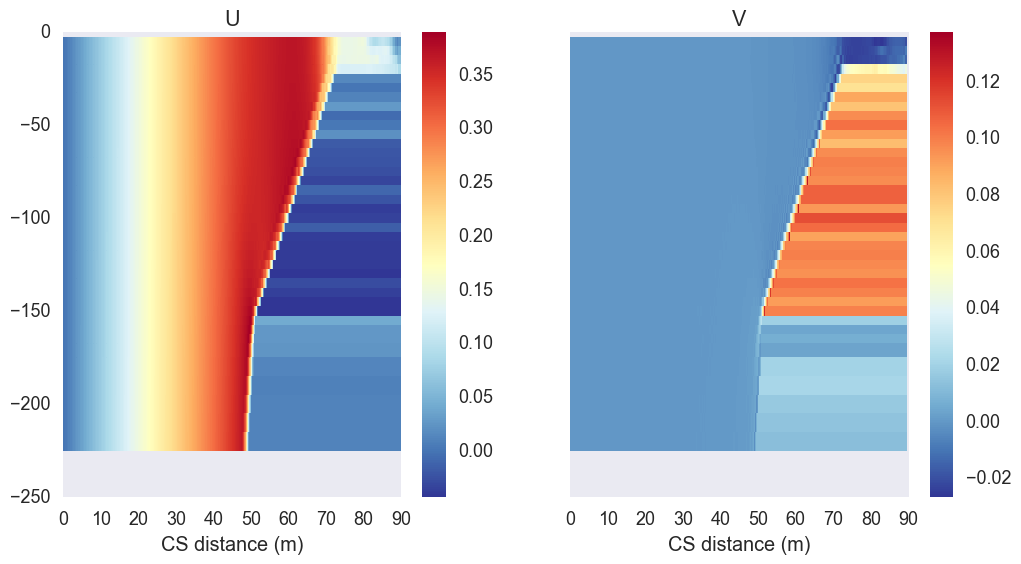

In [23]:
sns.set_context('talk')
fig,ax = plt.subplots(1,2,figsize=(12,6), sharey = True)

pcol1 = ax[0].pcolor(gridNoC.YC[:,120]/1000,gridNoC.RC[:40],UU_CS_ext[:40,:], cmap = 'RdYlBu_r')
plt.colorbar(pcol1,ax = ax[0])
ax[0].set_title('U')
ax[0].set_xlabel('CS distance (m)')

pcol2 = ax[1].pcolor(gridNoC.Yp1[:360]/1000,gridNoC.RC[:40],VV_CS_ext[:40,:], cmap = 'RdYlBu_r')
plt.colorbar(pcol2,ax = ax[1])
ax[1].set_title('V')
ax[1].set_xlabel('CS distance (m)')


print('Extended fields')

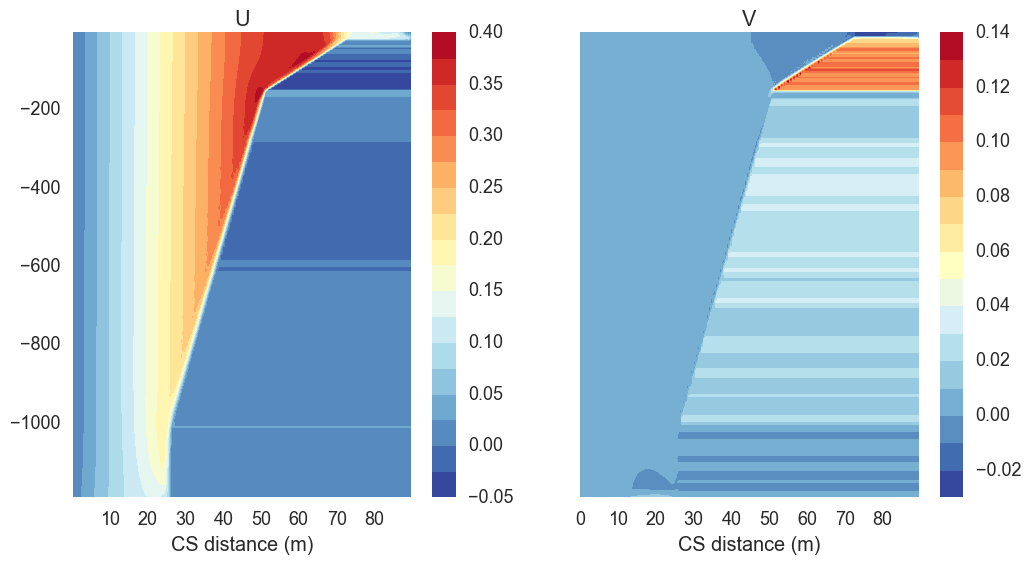

In [24]:
sns.set_context('talk')
fig,ax = plt.subplots(1,2,figsize=(12,6), sharey = True)

cf1 = ax[0].contourf(gridNoC.YC[:,120]/1000,gridNoC.RC[:],UU_CS_ext,20, cmap = 'RdYlBu_r')
plt.colorbar(cf1,ax = ax[0])
ax[0].set_title('U')
ax[0].set_xlabel('CS distance (m)')

cf2 = ax[1].contourf(gridNoC.Yp1[:360]/1000,gridNoC.RC[:],VV_CS_ext,20, cmap = 'RdYlBu_r')
plt.colorbar(cf2,ax = ax[1])
ax[1].set_title('V')
ax[1].set_xlabel('CS distance (m)')



In [25]:
# Extend cross section in alongshelf dimension (x) to get 3D fields. 
# - I am assuming coastal upwelling is symmetrical alongshelf, which sounds reasonable 
# and is what I see in the no canyon cases.-

UU_CS_exp = np.expand_dims(UU_CS_ext,2)
UU_CS_exp = UU_CS_exp + np.zeros(gridNoC.HFacC.shape)

VV_CS_exp = np.expand_dims(VV_CS_ext,2)
VV_CS_exp = VV_CS_exp + np.zeros(gridNoC.HFacC.shape)


print(UU_CS_exp.shape)

(90, 360, 360)


In [26]:
# Save IC's binary files

dt = np.dtype('>f8')  # float 64 big endian

IC_uu_file = "uu_run42_day03_canyon.bin"
fileobj1 = open(IC_uu_file,mode='wb')
np.array(UU_CS_exp).astype(dt).tofile(fileobj1,"")
fileobj1.close()

IC_vv_file = "vv_run42_day03_canyon.bin"
fileobj2 = open(IC_vv_file,mode='wb')
np.array(VV_CS_exp).astype(dt).tofile(fileobj2,"")
fileobj2.close()


(360, 360, 90)
(360, 360, 90)


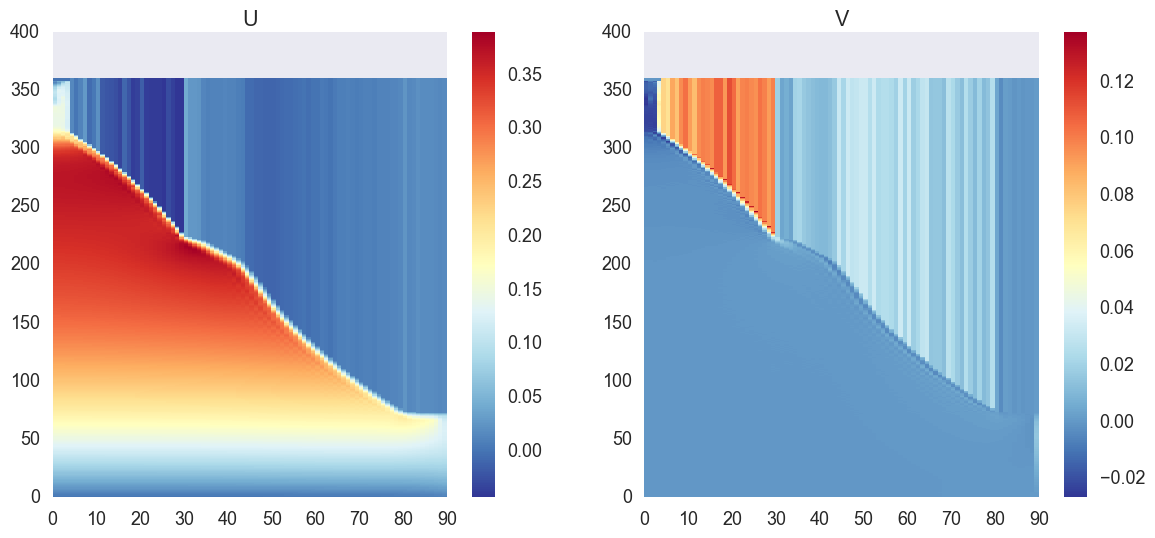

In [27]:
# Check what we wrote
fileNAME = "uu_run42_day03_canyon.bin" 
dataT = np.fromfile(fileNAME, dt)

T_check = np.reshape(dataT,(360,360,90),order='F')
print(T_check.shape)

fileNAME = "vv_run42_day03_canyon.bin" 
dataS = np.fromfile(fileNAME, dt)

S_check = np.reshape(dataS,(360,360,90),order='F')
print(S_check.shape)

sns.set_context('talk')
fig,ax = plt.subplots(1,2,figsize=(14,6))

pcol1 = ax[0].pcolor(T_check[120,:,:], cmap = 'RdYlBu_r')
plt.colorbar(pcol1,ax = ax[0])
ax[0].set_title('U')

pcol2 = ax[1].pcolor(S_check[120,:,:], cmap = 'RdYlBu_r')
plt.colorbar(pcol2,ax = ax[1])
ax[1].set_title('V')